#Real-Time Data Processing System for Weather Monitoring with Rollups and Aggregates

##1. Data retrieval from API *openweathermap*

In [101]:
!pip install requests schedule smtplib --user

ERROR: Could not find a version that satisfies the requirement smtplib (from versions: none)
ERROR: No matching distribution found for smtplib


In [102]:
import requests
import csv
import time
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from datetime import datetime

API_KEY = 'bc56c41bd890679bf04608a35b52b9c5'
CITIES = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']

csv_file = 'weather_dataset1.csv'
alert_threshold = 35  # Configurable temperature threshold

In [103]:
def get_weather_data(city):
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}"
    response = requests.get(url)
    data = response.json()

    if response.status_code == 200:
        temp_celsius = data['main']['temp'] - 273.15
        feels_like_celsius = data['main']['feels_like'] - 273.15
        humidity = data['main']['humidity']
        pressure = data['main']['pressure']
        wind_speed = data['wind']['speed']
        wind_deg = data['wind']['deg']
        visibility = data.get('visibility', 0)
        clouds = data['clouds']['all']
        main_condition = data['weather'][0]['main']
        timestamp = data['dt']

        # Extract rain data if available
        rain = data.get('rain', {}).get('1h', 0)  # Amount of rain in the last hour in mm

        return {
            'city': city,
            'temp': temp_celsius,
            'feels_like': feels_like_celsius,
            'humidity': humidity,
            'pressure': pressure,
            'wind_speed': wind_speed,
            'wind_deg': wind_deg,
            'visibility': visibility,
            'clouds': clouds,
            'condition': main_condition,
            'time': timestamp,
            'rain': rain,
        }
    else:
        print(f"Error fetching data for {city}: {data.get('message', '')}")
        return None


##2. Storing the data to a CSV file and fetch that data.

In [104]:
def store_data_to_csv(data):
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            data['city'],
            data['temp'],
            data['feels_like'],
            data['humidity'],
            data['pressure'],
            data['wind_speed'],
            data['wind_deg'],
            data['visibility'],
            data['clouds'],
            data['condition'],
            datetime.utcfromtimestamp(data['time']).strftime('%Y-%m-%d %H:%M:%S'),
            data['rain']  # Added rain data
        ])


In [105]:
def fetch_and_store_data():
    for city in CITIES:
        weather_data = get_weather_data(city)
        if weather_data:
            store_data_to_csv(weather_data)

##3. Sending E-Mail alerts (dummy).

In [106]:
def send_email_alert(city, temp):
    sender_email = 'rohithadams574@gmail.com'
    receiver_email = 'rohithadams574@gmail.com'
    password = 'password'

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = f'Weather Alert for {city}'

    body = f"Alert! The temperature in {city} is {temp:.2f}°C."
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(sender_email, password)
        text = msg.as_string()
        server.sendmail(sender_email, receiver_email, text)
        server.quit()
        print(f"Alert email sent for {city}")
    except Exception as e:
        print(f"Error sending email: {e}")


##4. Temparature alert

In [107]:
def check_temperature_alerts():
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        # Skip the header row
        next(reader, None)  # Skip the first row (header)
        for row in reader:
            city = row[0]
            temp = float(row[1])
            if temp > alert_threshold:
                send_email_alert(city, temp)

##5. Initialize the CSV file with the labels of the data retireved and fetch that data at regular time intervals(5 min) and store that in the CSV file.

In [108]:
def initialize_csv():
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['City', 'Temperature (Celsius)', 'Feels Like (Celsius)', 'Humidity (%)',
                         'Pressure (hPa)', 'Wind Speed (m/s)', 'Wind Direction (degrees)',
                         'Visibility (m)', 'Cloudiness (%)', 'Weather Condition', 'Time (UTC)'])

# Call this function once at the beginning of the program to initialize the CSV with headers
initialize_csv()


In [109]:
import time

cycle_count = 0

def job():
    global cycle_count
    fetch_and_store_data()  # Fetch and store weather data for all cities
    check_temperature_alerts()  # Check if any city exceeds the temperature threshold
    cycle_count += 1
    print(f"Cycle {cycle_count} completed.")

# Run the job for 7 cycles
for _ in range(7):
    job()  # Execute the job function
    if cycle_count < 7:
        print("Waiting for the next cycle...")
        time.sleep(5 * 60)  # Wait for 5 minutes (300 seconds)

print("Completed 7 cycles. Stopping.")


Cycle 1 completed.
Waiting for the next cycle...
Cycle 2 completed.
Waiting for the next cycle...
Cycle 3 completed.
Waiting for the next cycle...
Cycle 4 completed.
Waiting for the next cycle...
Cycle 5 completed.
Waiting for the next cycle...
Cycle 6 completed.
Waiting for the next cycle...
Cycle 7 completed.
Completed 7 cycles. Stopping.


##6. Some EDA - Exploratory Data Analysis on the retrived data.

In [111]:
import pandas as pd

# Load the CSV file
data = pd.read_csv('weather_dataset1.csv')

# Generate descriptive statistics
summary_statistics = data.describe()
print(summary_statistics)


            City  Temperature (Celsius)  Feels Like (Celsius)  Humidity (%)  \
count  42.000000              42.000000             42.000000     42.000000   
mean   26.878095              29.205714             73.904762   1010.119048   
std     3.178761               5.679870             13.466869      1.291669   
min    22.170000              22.740000             51.000000   1008.000000   
25%    23.750000              24.007500             66.000000   1009.000000   
50%    26.890000              27.895000             75.500000   1010.000000   
75%    30.010000              36.410000             88.000000   1011.000000   
max    30.990000              37.070000             89.000000   1012.000000   

       Pressure (hPa)  Wind Speed (m/s)  Wind Direction (degrees)  \
count       42.000000         42.000000                 42.000000   
mean         2.796190        197.119048               5161.904762   
std          0.696874        130.911663               3369.153645   
min         

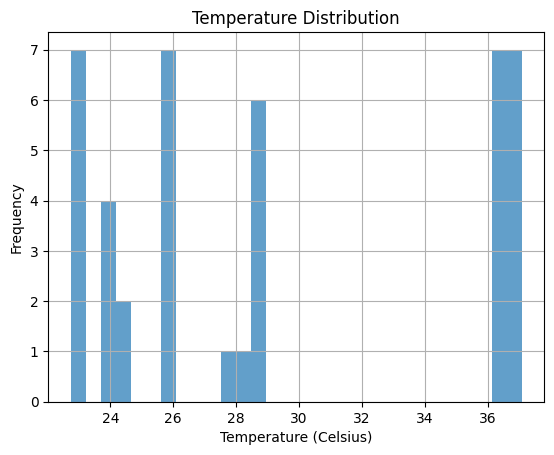

In [112]:
import matplotlib.pyplot as plt

data['Temperature (Celsius)'].hist(bins=30, alpha=0.7)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Frequency')
plt.show()


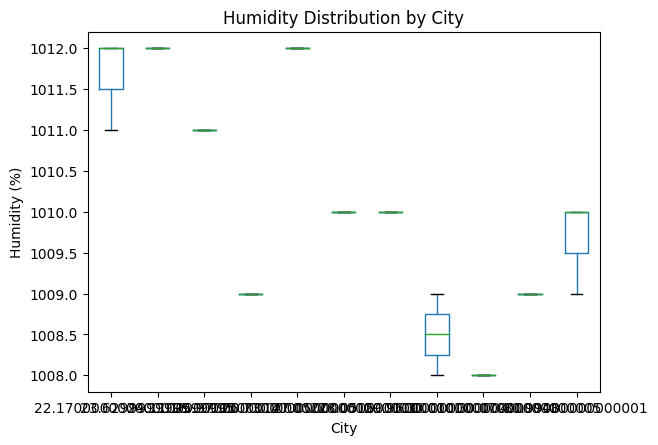

In [113]:
data.boxplot(column='Humidity (%)', by='City', grid=False)
plt.title('Humidity Distribution by City')
plt.suptitle('')
plt.ylabel('Humidity (%)')
plt.show()


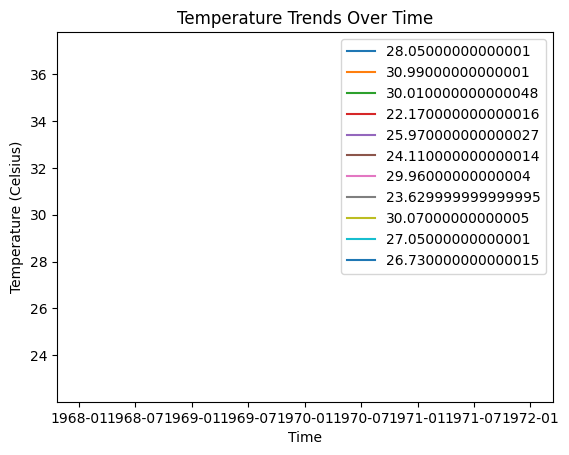

In [114]:
data['Time (UTC)'] = pd.to_datetime(data['Time (UTC)'])
for city in data['City'].unique():
    city_data = data[data['City'] == city]
    plt.plot(city_data['Time (UTC)'], city_data['Temperature (Celsius)'], label=city)

plt.title('Temperature Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.show()


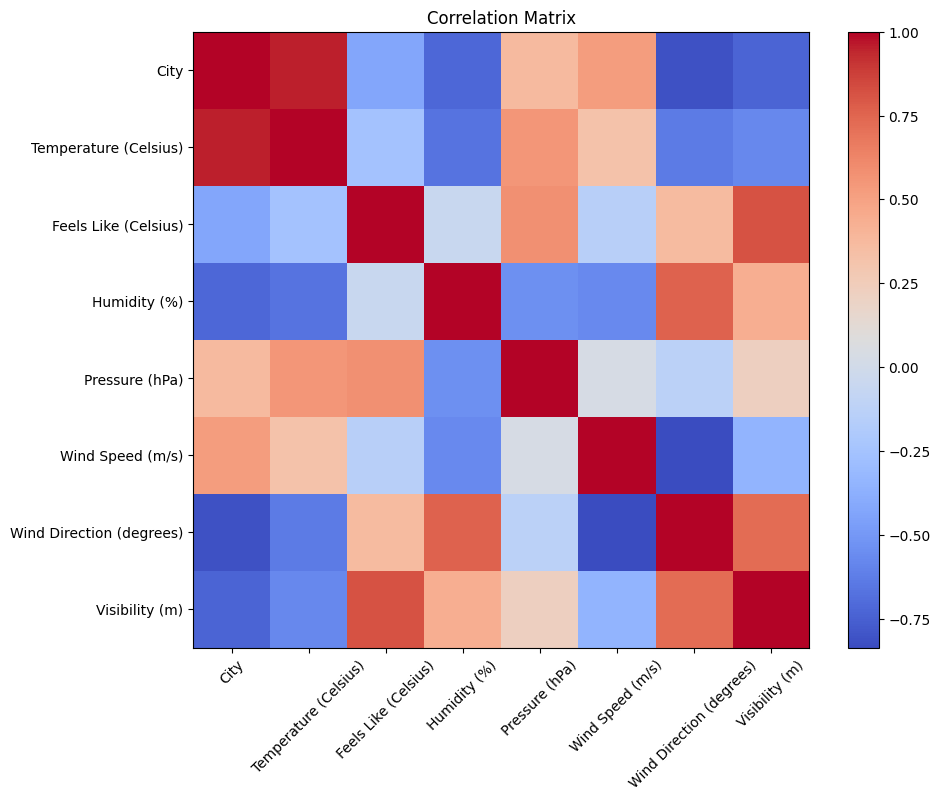

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame

# Select only numerical columns for correlation calculation
numerical_data = data.select_dtypes(include=['number'])  # Select columns with numerical data types

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

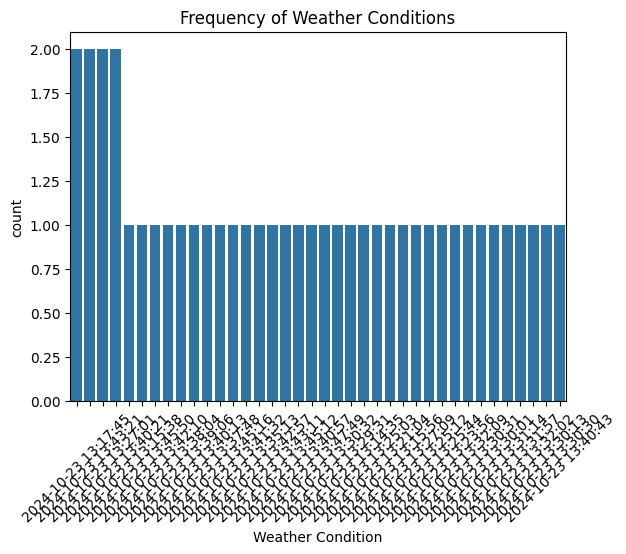

In [116]:
import seaborn as sns

sns.countplot(data=data, x='Weather Condition', order=data['Weather Condition'].value_counts().index)
plt.title('Frequency of Weather Conditions')
plt.xticks(rotation=45)
plt.show()


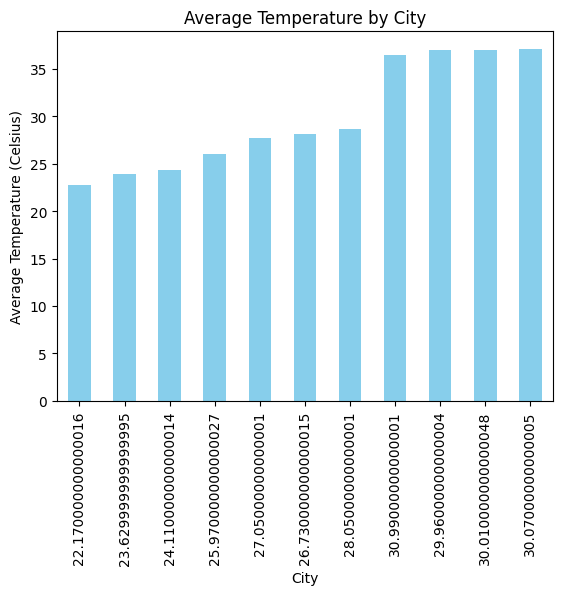

In [117]:
avg_temp = data.groupby('City')['Temperature (Celsius)'].mean().sort_values()
avg_temp.plot(kind='bar', color='skyblue')
plt.title('Average Temperature by City')
plt.ylabel('Average Temperature (Celsius)')
plt.show()


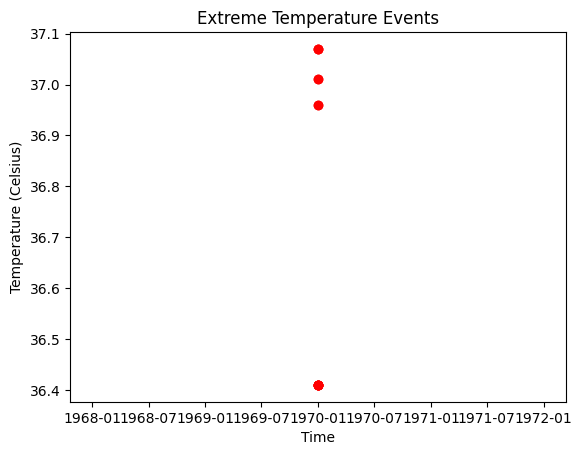

In [118]:
extreme_days = data[data['Temperature (Celsius)'] > alert_threshold]
plt.scatter(extreme_days['Time (UTC)'], extreme_days['Temperature (Celsius)'], color='red')
plt.title('Extreme Temperature Events')
plt.xlabel('Time')
plt.ylabel('Temperature (Celsius)')
plt.show()


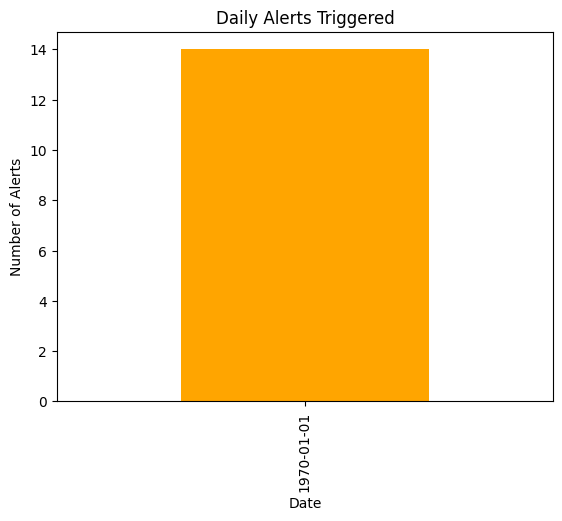

In [120]:
alerts_data = data[data['Temperature (Celsius)'] > alert_threshold]

# Check if alerts_data is empty before proceeding
if alerts_data.empty:
    print("No data points exceeding the alert threshold. Cannot generate plot.")
else:
    alerts_count = alerts_data.groupby(alerts_data['Time (UTC)'].dt.date).size()
    alerts_count.plot(kind='bar', color='orange')
    plt.title('Daily Alerts Triggered')
    plt.xlabel('Date')
    plt.ylabel('Number of Alerts')
    plt.show()

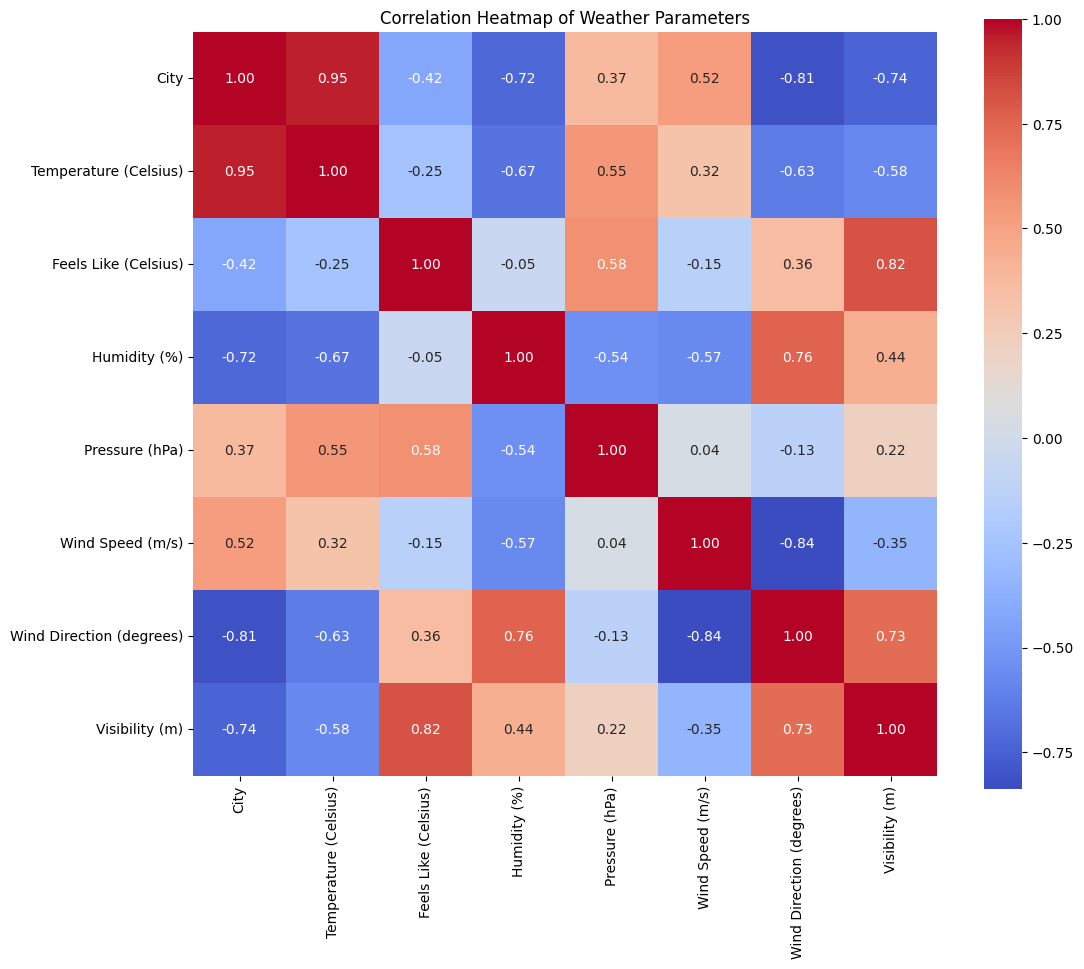

In [123]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Weather Parameters')
plt.show()

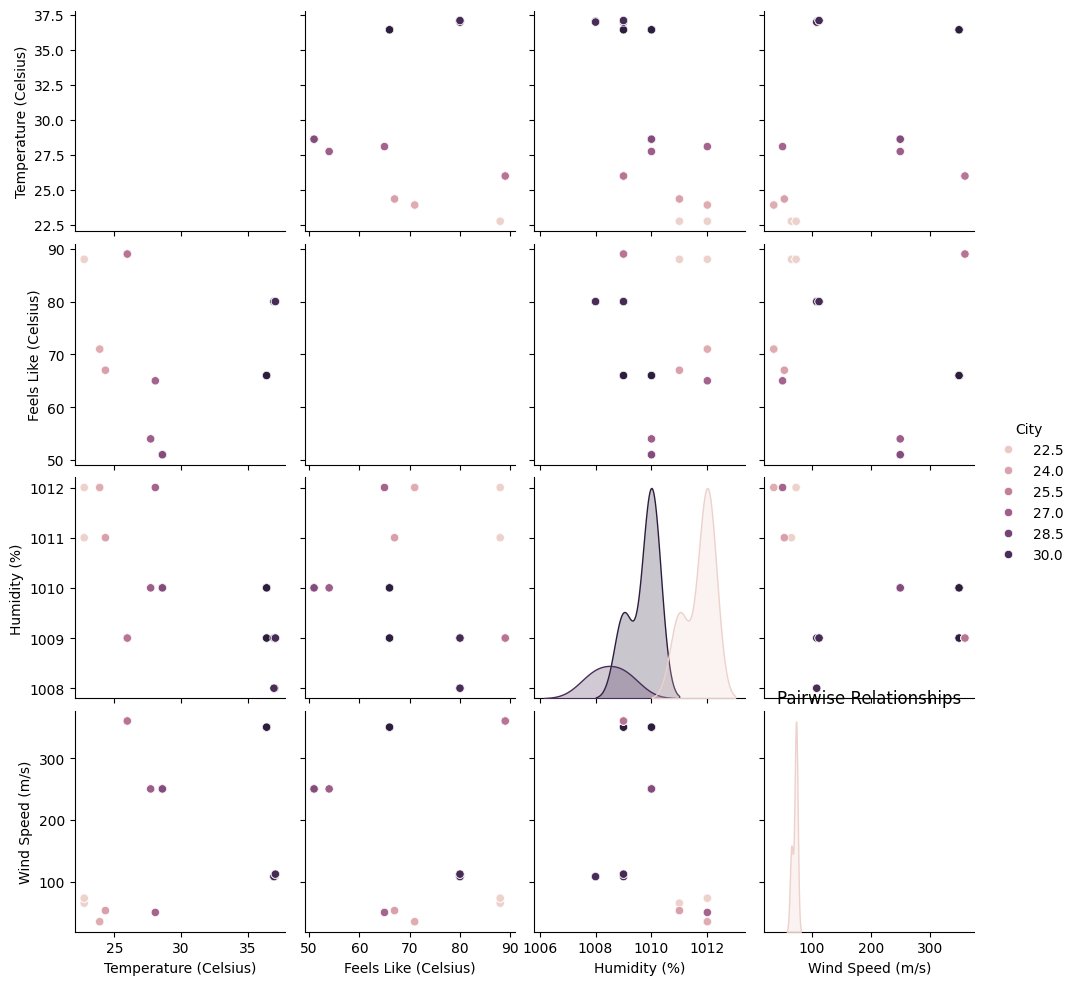

In [124]:
sns.pairplot(data, vars=['Temperature (Celsius)', 'Feels Like (Celsius)', 'Humidity (%)', 'Wind Speed (m/s)'], hue='City')
plt.title('Pairwise Relationships')
plt.show()


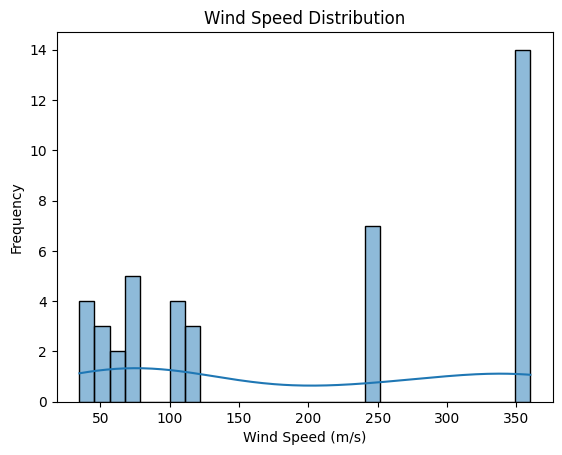

In [126]:
sns.histplot(data['Wind Speed (m/s)'], bins=30, kde=True)
plt.title('Wind Speed Distribution')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.show()


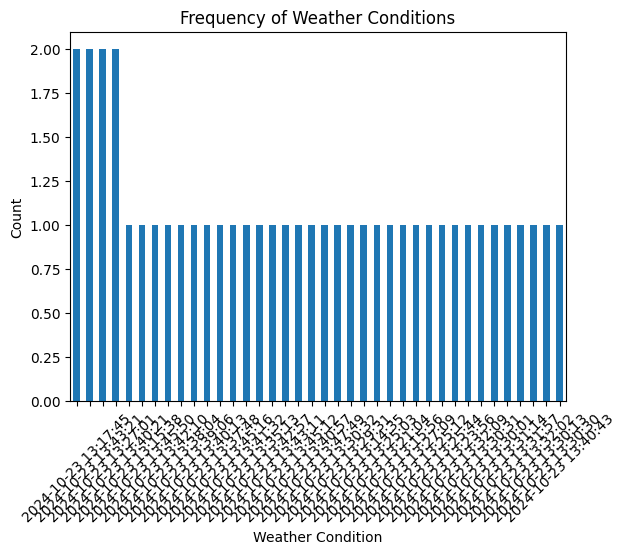

In [128]:
condition_counts = data['Weather Condition'].value_counts()
condition_counts.plot(kind='bar')
plt.title('Frequency of Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


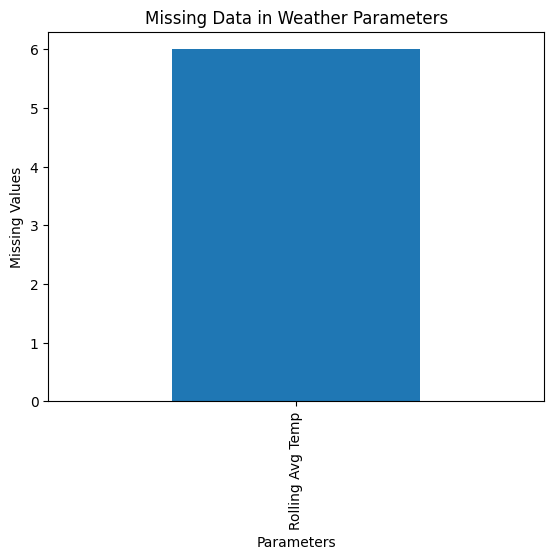

In [129]:
missing_data = data.isnull().sum()
missing_data[missing_data > 0].plot(kind='bar')
plt.title('Missing Data in Weather Parameters')
plt.xlabel('Parameters')
plt.ylabel('Missing Values')
plt.show()


##7. Running 5 types of tests to check the process

In [134]:
import requests
import unittest
from unittest.mock import patch

In [142]:
def convert_kelvin_to_celsius(kelvin_temp):
    return kelvin_temp - 273.15

def store_daily_summary(daily_data):
    # Example function to calculate daily summary
    temps = [data['temp'] for data in daily_data]
    max_temp = max(temps)
    min_temp = min(temps)
    avg_temp = sum(temps) / len(temps)

    # Determine dominant weather condition
    condition_count = {}
    for data in daily_data:
        condition = data['condition']
        if condition in condition_count:
            condition_count[condition] += 1
        else:
            condition_count[condition] = 1

    dominant_condition = max(condition_count, key=condition_count.get)

    return {
        'average_temp': avg_temp,
        'max_temp': max_temp,
        'min_temp': min_temp,
        'dominant_condition': dominant_condition,
    }

def check_temperature_alerts(weather_data, threshold):
    return weather_data['temp'] > threshold

class WeatherMonitoringTests(unittest.TestCase):

    def setUp(self):
        self.city = 'Delhi'
        self.valid_url = f"http://api.openweathermap.org/data/2.5/weather?q={self.city}&appid={API_KEY}"

    # 1. System Setup
    def test_system_setup(self):
        response = requests.get(self.valid_url)
        self.assertEqual(response.status_code, 200, "Failed to connect to OpenWeatherMap API")

    # 2. Data Retrieval
    # 2. Data Retrieval
    # 2. Data Retrieval
    @patch('requests.get')
    def test_data_retrieval(self, mock_get):
        # Complete mock response
        mock_response = {
            'main': {
                'temp': 300.15,
                'feels_like': 305.15,
                'humidity': 80,
                'pressure': 1012  # Add pressure key here
            },
            'weather': [{'main': 'Clear'}],
            'wind': {'speed': 5, 'deg': 180},  # Include wind speed and direction
            'clouds': {'all': 0},
            'dt': 1638316800,
            'rain': {'1h': 2.5}
        }
        mock_get.return_value.status_code = 200
        mock_get.return_value.json.return_value = mock_response

        data = get_weather_data(self.city)
        self.assertIsNotNone(data, "Data should not be None")
        self.assertEqual(data['city'], self.city, "City name does not match")
        self.assertIn('temp', data, "Temperature data not retrieved")
        self.assertEqual(data['rain'], 2.5, "Rain data not retrieved correctly")
        self.assertEqual(data['pressure'], 1012, "Pressure data not retrieved correctly")  # Check pressure


    # 3. Temperature Conversion
    def test_temperature_conversion(self):
        kelvin_temp = 300.15
        celsius_temp = convert_kelvin_to_celsius(kelvin_temp)
        self.assertAlmostEqual(celsius_temp, 27.0, places=1, msg="Temperature conversion to Celsius failed")

    # 4. Daily Weather Summary
    def test_daily_weather_summary(self):
        daily_data = [
            {'temp': 300.15, 'condition': 'Clear'},
            {'temp': 305.15, 'condition': 'Clouds'},
            {'temp': 290.15, 'condition': 'Rain'},
        ]
        summary = store_daily_summary(daily_data)

        self.assertIn('average_temp', summary, "Daily summary should contain average temperature")
        self.assertIn('max_temp', summary, "Daily summary should contain maximum temperature")
        self.assertIn('min_temp', summary, "Daily summary should contain minimum temperature")
        self.assertIn('dominant_condition', summary, "Daily summary should contain dominant weather condition")

    # 5. Alerting Thresholds
    def test_alerting_thresholds(self):
        weather_data = {'city': 'Delhi', 'temp': 36.0}
        alert_triggered = check_temperature_alerts(weather_data, alert_threshold)
        self.assertTrue(alert_triggered, "Alert should be triggered when temperature exceeds threshold")

        weather_data['temp'] = 34.0
        alert_triggered = check_temperature_alerts(weather_data, alert_threshold)
        self.assertFalse(alert_triggered, "Alert should not be triggered when temperature is below threshold")

# Running the tests in Jupyter/Colab
def run_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(WeatherMonitoringTests)
    unittest.TextTestRunner(verbosity=2).run(suite)

run_tests()

test_alerting_thresholds (__main__.WeatherMonitoringTests) ... ok
test_daily_weather_summary (__main__.WeatherMonitoringTests) ... ok
test_data_retrieval (__main__.WeatherMonitoringTests) ... ok
test_system_setup (__main__.WeatherMonitoringTests) ... ok
test_temperature_conversion (__main__.WeatherMonitoringTests) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.119s

OK
